# Homework 5

# Задача №1 - Можете ли вы отличить сорняки от рассады?

Теперь приступим к задаче классификации на картинках. Реализуйте программу, которая определяет тип рассады на изображении. 

Для того, чтобы определить характерные особенности каждого типа рассады, у вас есть train. Train это папка, в которой картинки уже классифицированы и лежат в соответствующих папках. Исходя из этой информации можете найти признаки, присущие конкретному растению.

Проверка вашего решения будет на происходить на test. В папке test уже нет метки класса для каждой картинки. 

[Ссылка на Яндекс-диск](https://yadi.sk/d/0Zzp0klXT0iRmA), все картинки тут.

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [1]:
import cv2
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from typing import List, Any, Tuple, Union

In [2]:
def preproc(img: cv2.Mat)-> cv2.Mat:
    """
    Deliting all non green zones from image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img[img[:, :, 0] < 35] = (0, 0, 0)
    img[img[:, :, 0] > 85] = (0, 0, 0)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [3]:
class Descriptor:
    """ 
    Class with SIFT descriptor calculator
    """
    def __init__(self, hyp_params=None):
        if hyp_params is None:
            hyp_params = dict(
                nfeatures = 150,
                nOctaveLayers = 8,
                contrastThreshold = 0.01,
                edgeThreshold = 10,
                sigma = 4
            )  
        self.detector = cv2.SIFT_create(**hyp_params)

    def get_desc(self, img: cv2.Mat) -> Any:
        key_points, desc = self.detector.detectAndCompute(img, None)
        return key_points, desc
        

In [4]:
def get_data(data: List, descer: Descriptor) -> Tuple[List, List]:
    X = []
    y = []
    my_descer = Descriptor()
    for img, cls in tqdm(data):
        desc = np.mean(my_descer.get_desc(img)[1], axis=0)
        X += [desc]
        y += [cls]
    return X, y

In [5]:
test_target =  [
    0, 0, 1, 1, 0, 0, 2, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, \
    2, 2, 3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1
] # Hand marked targets to measure score of model

In [6]:
plants_img = {
    "test": [],
    "train": []
}

for i, img in enumerate(os.listdir("plants/test/")):
    plants_img["test"] += [(
        preproc(cv2.imread("plants/test/"+img)),
        test_target[i]
    )]
    
for i, cls in enumerate(os.listdir("plants/train/")):
    for img in os.listdir("plants/train/"+cls):
        plants_img["train"] += [(
            preproc(cv2.imread("plants/train/"+cls+"/"+img)),
            i
        )]

In [7]:
my_descer = Descriptor()
X_train, y_train = get_data(plants_img["train"], my_descer)
X_test, y_test = get_data(plants_img["test"], my_descer)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
model_type = "svm"

if model_type == "svm":
    model = SVC()
elif model_type == "tree":
    model = RandomForestClassifier()
else:
    raise ValueError("Incorrect model type")

model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy {accuracy}")

Accuracy 0.85


# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

## Vizualize puzzles

In [9]:
def show_parts(img_parts: List) -> None:
    """
    Showing images in given list
    """
    if len(img_parts) == 0:
        return
    elif len(img_parts) == 1:
        plt.imshow(img_parts[0])
        return
        
    
    n_cols = int(len(img_parts)**0.5) + 1
    n_rows = len(img_parts) // n_cols + 1
    _, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(10, 10))
    
    for i in range(len(img_parts)):
        ax[i // n_cols][i % n_cols].imshow(img_parts[i])
        ax[i // n_cols][i % n_cols].set_axis_off()
    
    # Turn of the axis on the rest of the subplots
    for i in range(len(img_parts), n_cols*n_rows):
        ax[i // n_cols][i % n_cols].set_axis_off()
            
    plt.show()

In [10]:
plane_parts = []
for img_name in os.listdir("puzzle/su_fighter_shuffle/"):
    img = cv2.imread("puzzle/su_fighter_shuffle/"+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plane_parts += [img]

In [11]:
chine_parts = []
for img_name in os.listdir("puzzle/china_shuffle/"):
    img = cv2.imread("puzzle/china_shuffle/"+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    chine_parts += [img]

In [12]:
home_parts = []
for img_name in os.listdir("puzzle/home_shuffle/"):
    img = cv2.imread("puzzle/home_shuffle/"+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    home_parts += [img]

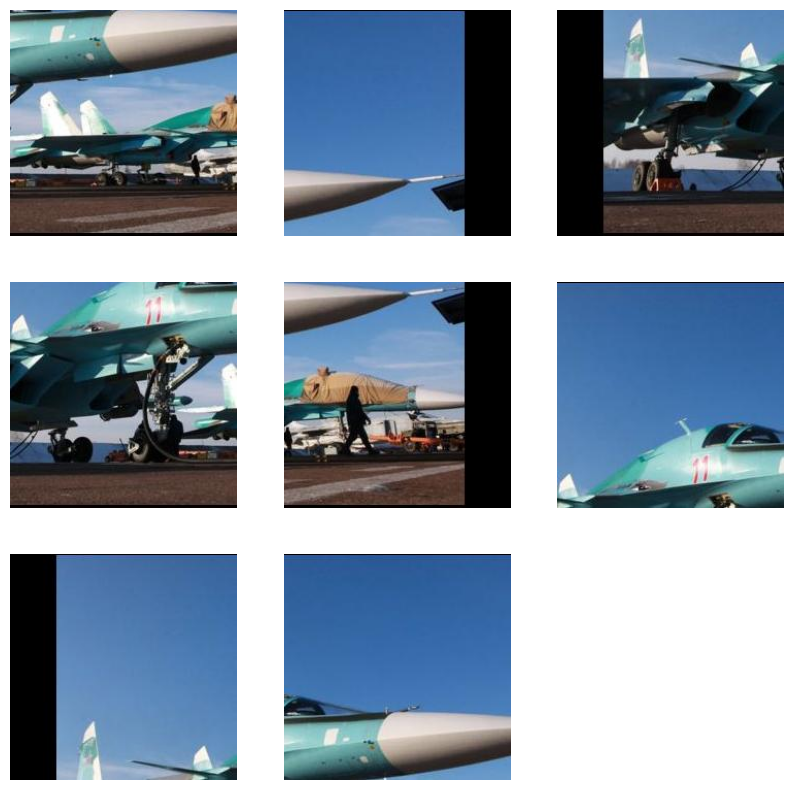

In [13]:
show_parts(plane_parts)

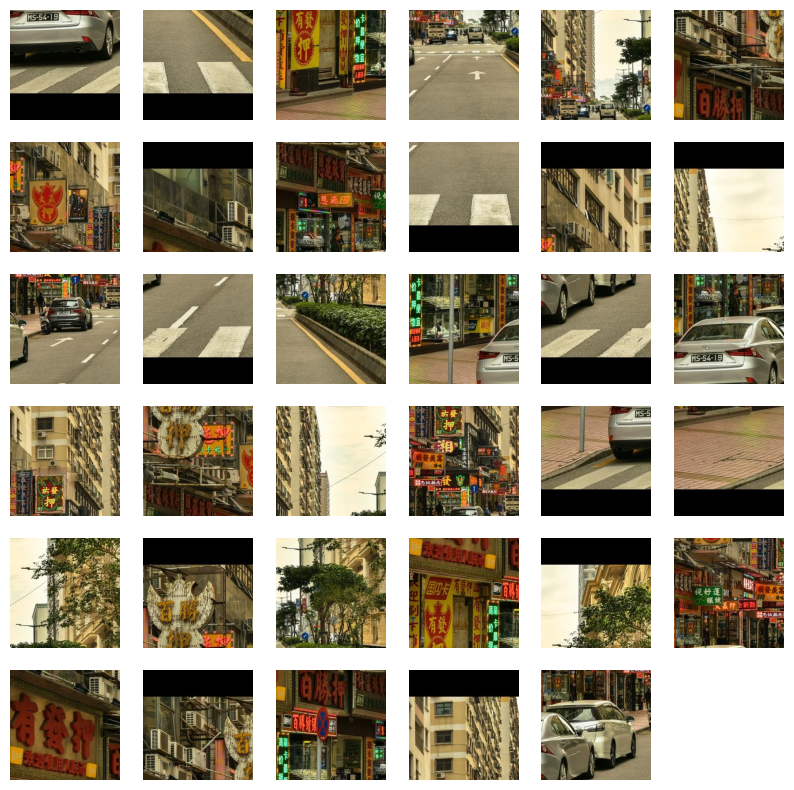

In [14]:
show_parts(chine_parts)

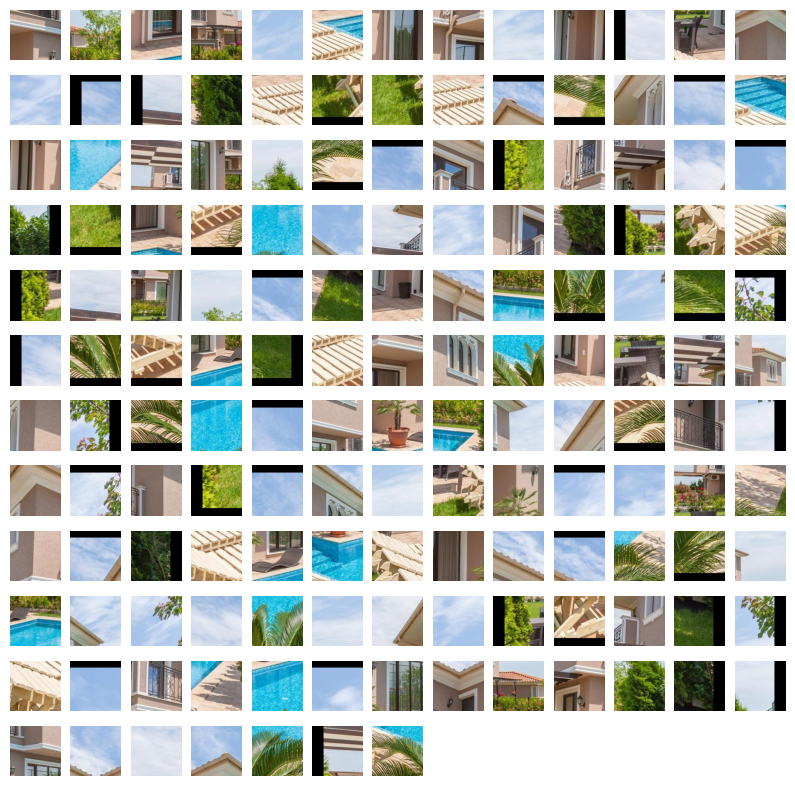

In [15]:
show_parts(home_parts)

## Let's start combining those pieces together

In [16]:
def puzzle_preproc(img: cv2.Mat, prep_type: str = "GRAY") -> cv2.Mat:
    """
    Preprocessing of image
    """
    new_img = img.copy()
    if prep_type == "GRAY":
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
    return new_img

In [17]:
class Matcher:
    def __init__(self, matcher_type: str = "BF", ratio_thresh:float = 0.7):
        """ Saving matchers """
        FLANN_INDEX_KDTREE = 2
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)
        
        self.matcher_type=matcher_type

        if self.matcher_type == "FLANN":
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
        elif self.matcher_type == "BF":
            self.matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
        else:
            raise ValueError("incorrect mathcer type")
        
        
        self.ratio_thresh = ratio_thresh
    
    def get_good_matches(self, desc1: Any, desc2: Any) -> List:
        """
        Discovering good matches of desc1 and desc2 with matcher of
        type matcher_type.
        
        Input:
            desc1 - SIFT descriptor of first image
            desc2 - SIFT descriptor of second image
        
        Return:
            list of good matching points
        """
        matches = self.matcher.knnMatch(desc1, desc2, k=2)
        
        good_matches = []
        for m, n in matches:
            if m.distance < self.ratio_thresh * n.distance:
                good_matches += [m]
        
        return good_matches
    
    def get_good_points(self, kp1: Any, kp2: Any, good_matches: List) -> List:
        """
        Extracting good key points 
        """
        good_points = []
        for match in good_matches:
            x1, y1 = kp1[match.queryIdx].pt
            x2, y2 = kp2[match.trainIdx].pt
            good_points += [(x1, y1, x2, y2)]
        return good_points

In [18]:
class Sticher:
    def __init__(
        self,
        max_iter:Union[int, None] = None,
        prep_type:str = "GRAY",
        ratio_thresh: float = 0.6,
        point_count:int = 1,
        hyp_params: Union[dict, None] = None
    ):
        self.matcher = Matcher(matcher_type="BF", ratio_thresh=ratio_thresh)
        self.descer = Descriptor(hyp_params)
        
        self.max_iter = max_iter
        self.point_count = point_count
        self.prep_type = prep_type
    
    def stich2picies(
        self,
        img1: cv2.Mat,
        point1:np.ndarray,
        img2: cv2.Mat,
        point2:np.ndarray
    ) -> cv2.Mat:
        """
        Stiching 2 images by their key points
        
        Input:
            img1 - first image
            point1 - first key point. List of coordinates [y1, x1]
            img2  - second image
            point2 - second key point List of coordinates [y2, x2]
        
        Return:
            np.array - resuting stiched image
        """
        delta_vec = point1 - point2 + img2.shape[:-1]
        shape_y = img2.shape[0]
        shape_x = img2.shape[1]
        
        value = (0, 0, 0)
        if self.prep_type == "GRAY":
            value = 0
            
        new_img = cv2.copyMakeBorder(
            img1, shape_y, shape_y, shape_x, shape_x,
            cv2.BORDER_CONSTANT, value=value
        )
        
        new_img[
            delta_vec[0]: shape_y + delta_vec[0],
            delta_vec[1]: shape_x + delta_vec[1]
        ] = img2
        
        l_edge = min(delta_vec[1], shape_x)
        u_edge = min(delta_vec[0], shape_y)
        r_edge = max(delta_vec[1] + shape_x, shape_x + img1.shape[1])
        d_edge = max(delta_vec[0] + shape_y, shape_y + img1.shape[0])
        
        new_img = new_img[
            u_edge: d_edge,
            l_edge: r_edge
        ]
        
        return new_img
    
    def stich_pieces(self, pieces: List) -> Tuple[cv2.Mat, List, List]:
        """
        Solving a given puzzle
        """
        base_img = puzzle_preproc(pieces[0], prep_type=self.prep_type)
        pieces = np.delete(pieces, 0, axis=0)
        
        curr_iter = 0
        history = [base_img]
        
        if self.max_iter is None:
            self.max_iter = len(pieces)
        
        with tqdm(total=max(self.max_iter, len(pieces))) as pbar:
            while len(pieces) != 0 and curr_iter < self.max_iter:
                kp_base, desc_base = self.descer.get_desc(base_img)
                kp_part, desc_part = None, None
                choosen_idx = None
                part_img = None
                good_matches = []
                
                for tmp_idx in range(len(pieces)):
                    tmp_img = puzzle_preproc(pieces[tmp_idx], prep_type=self.prep_type)
                    kp_part, desc_part = self.descer.get_desc(tmp_img)
                    good_matches = self.matcher.get_good_matches(desc_base, desc_part)
                    
                    if len(good_matches) >= self.point_count:
                        choosen_idx = tmp_idx
                        part_img = tmp_img
                        break
                
                # print("MATCHES_LEN", len(good_matches))
                if part_img is None:
                    curr_iter += 1
                    pbar.update(1)
                    continue
                
                good_points = self.matcher.get_good_points(
                    kp_base, kp_part, good_matches
                )
                
                x1, y1, x2, y2 = good_points[0]
                
                base_img = self.stich2picies(
                    base_img, np.array([y1, x1], dtype=np.int16),
                    part_img, np.array([y2, x2], dtype=np.int16)
                )
                history += [base_img]
                pieces = np.delete(pieces, choosen_idx, axis=0)
                
                curr_iter += 1
                pbar.update(1)
                
        return base_img, history, pieces
            
        
        

  0%|          | 0/7 [00:00<?, ?it/s]

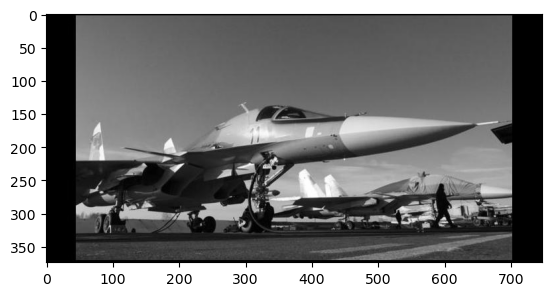

In [19]:
hyp_params = dict(
    nfeatures = 250,
    nOctaveLayers = 3,
    contrastThreshold = 0.01,
    edgeThreshold = 5,
    sigma = 4
) 

ratio_thresh = 0.3
point_count = 1

sticher = Sticher(
    ratio_thresh=ratio_thresh,
    point_count=point_count,
    hyp_params=hyp_params
)
result, history, last_pieces = sticher.stich_pieces(plane_parts)

# Я не понимаю почему у меня цвет не преобразуется.
# Вроде всё нормально работало, а потом просто перестал 
# из gray в rgb возвращаться 
result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
plt.imshow(result)

  0%|          | 0/34 [00:00<?, ?it/s]

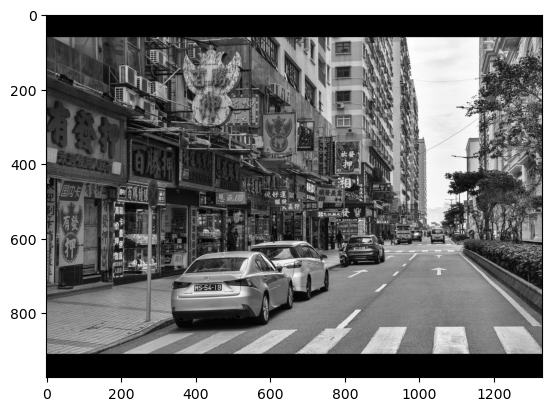

In [20]:
hyp_params = dict(
    nfeatures = 450,
    nOctaveLayers = 25,
    contrastThreshold = 0.01,
    edgeThreshold = 10,
    sigma = 3.9
) 

ratio_thresh = 0.3
point_count = 1

sticher = Sticher(
    ratio_thresh=ratio_thresh,
    point_count=point_count,
    hyp_params=hyp_params
)
result, history, last_pieces = sticher.stich_pieces(chine_parts)

# Тоже самое, что и в предыдущей ячейке
result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
plt.imshow(result)

  0%|          | 0/149 [00:00<?, ?it/s]

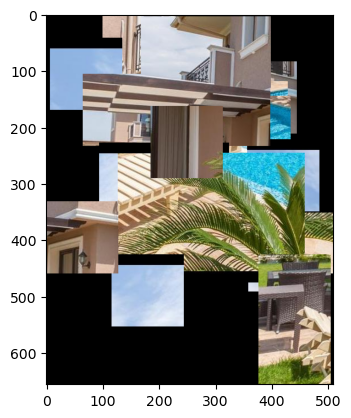

In [21]:
hyp_params = dict(
    nfeatures = 550,
    nOctaveLayers = 65,
    contrastThreshold = 0.001,
    edgeThreshold = 20,
    sigma = 3
) 

ratio_thresh = 0.5
point_count = 2

sticher = Sticher(
    # max_iter=30,
    prep_type="",
    ratio_thresh=ratio_thresh,
    point_count=point_count,
    hyp_params=hyp_params
)
result, history, last_pieces = sticher.stich_pieces(home_parts)
plt.imshow(result)